<a href="https://www.kaggle.com/code/subhajeetdas/star-type-classification-using-pipelines?scriptVersionId=161471402" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import zscore
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/astronomical-data/cleaned_star_data.csv


# Importing Data

In [2]:
df = pd.read_csv('/kaggle/input/astronomical-data/cleaned_star_data.csv')

In [3]:
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,White,A
238,9235,404940.000000,1112.0000,-11.23,5,White,A


# Dataset Information and Visualization

## Target Classes 
* 0 -> Brown Type
* 1 -> Red Dwarf
* 2 -> White Dwarf
* 3 -> Main Sequence
* 4 -> Supergiants
* 5 -> Hypergiants

<Axes: >

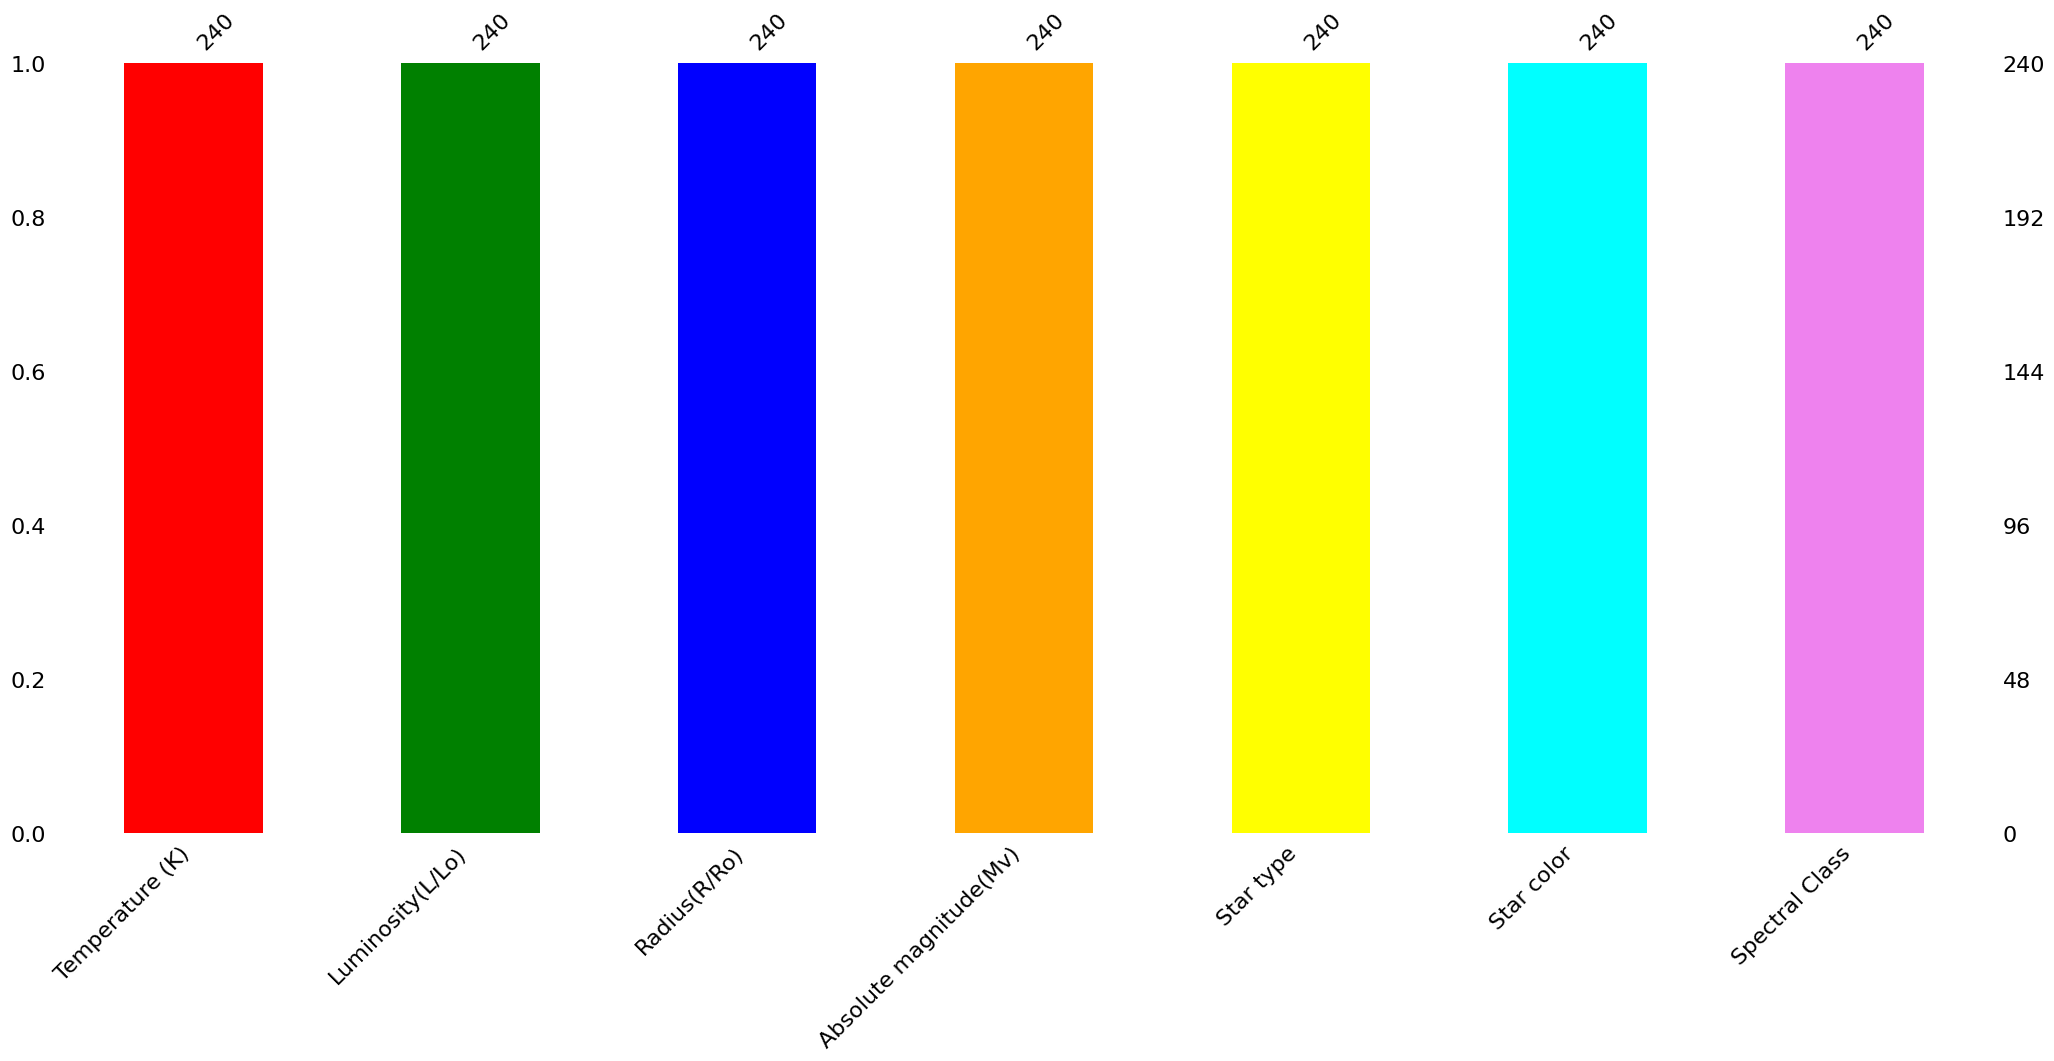

In [4]:
msno.bar(df, color = ['red', 'green', 'blue', 'orange', 'yellow', 'cyan', 'violet'])

In [5]:
df.dtypes

Temperature (K)             int64
Luminosity(L/Lo)          float64
Radius(R/Ro)              float64
Absolute magnitude(Mv)    float64
Star type                   int64
Star color                 object
Spectral Class             object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [7]:
df.shape

(240, 7)

In [8]:
df.size

1680

In [9]:
df['Spectral Class'].unique()

array(['M', 'B', 'A', 'F', 'O', 'K', 'G'], dtype=object)

In [10]:
df['Star color'].unique()

array(['Red', 'Blue-White', 'White', 'Yellow-White', 'Blue'], dtype=object)

In [11]:
df['Spectral Class'].value_counts()

Spectral Class
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: count, dtype: int64

In [12]:
df['Star color'].value_counts()

Star color
Red             116
Blue             56
Blue-White       41
Yellow-White     15
White            12
Name: count, dtype: int64

In [13]:
le = LabelEncoder()
df['Star color'] = le.fit_transform(df['Star color'])
df['Spectral Class'] = le.fit_transform(df['Spectral Class'])
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,2,5
1,3042,0.000500,0.1542,16.60,0,2,5
2,2600,0.000300,0.1020,18.70,0,2,5
3,2800,0.000200,0.1600,16.65,0,2,5
4,1939,0.000138,0.1030,20.06,0,2,5
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,0,6
236,30839,834042.000000,1194.0000,-10.63,5,0,6
237,8829,537493.000000,1423.0000,-10.73,5,3,0
238,9235,404940.000000,1112.0000,-11.23,5,3,0


<Axes: >

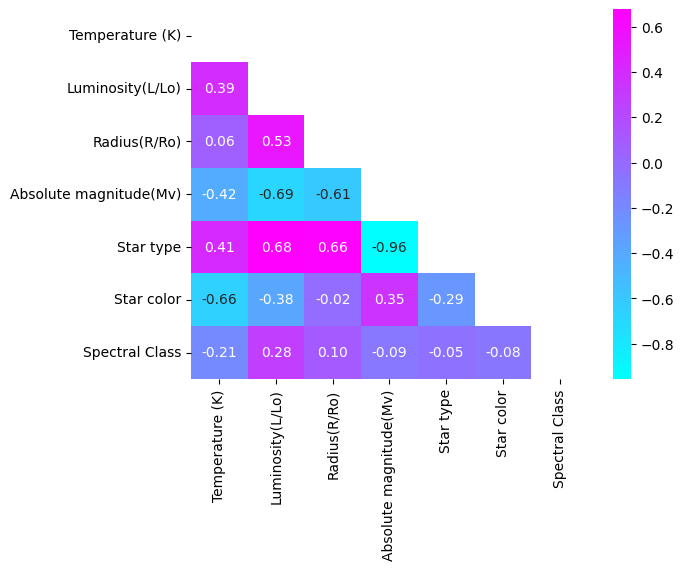

In [14]:
mask = np.triu(df.corr())

sns.heatmap(df.corr(), mask = mask, annot = True, fmt = '.2f', cmap = 'cool')

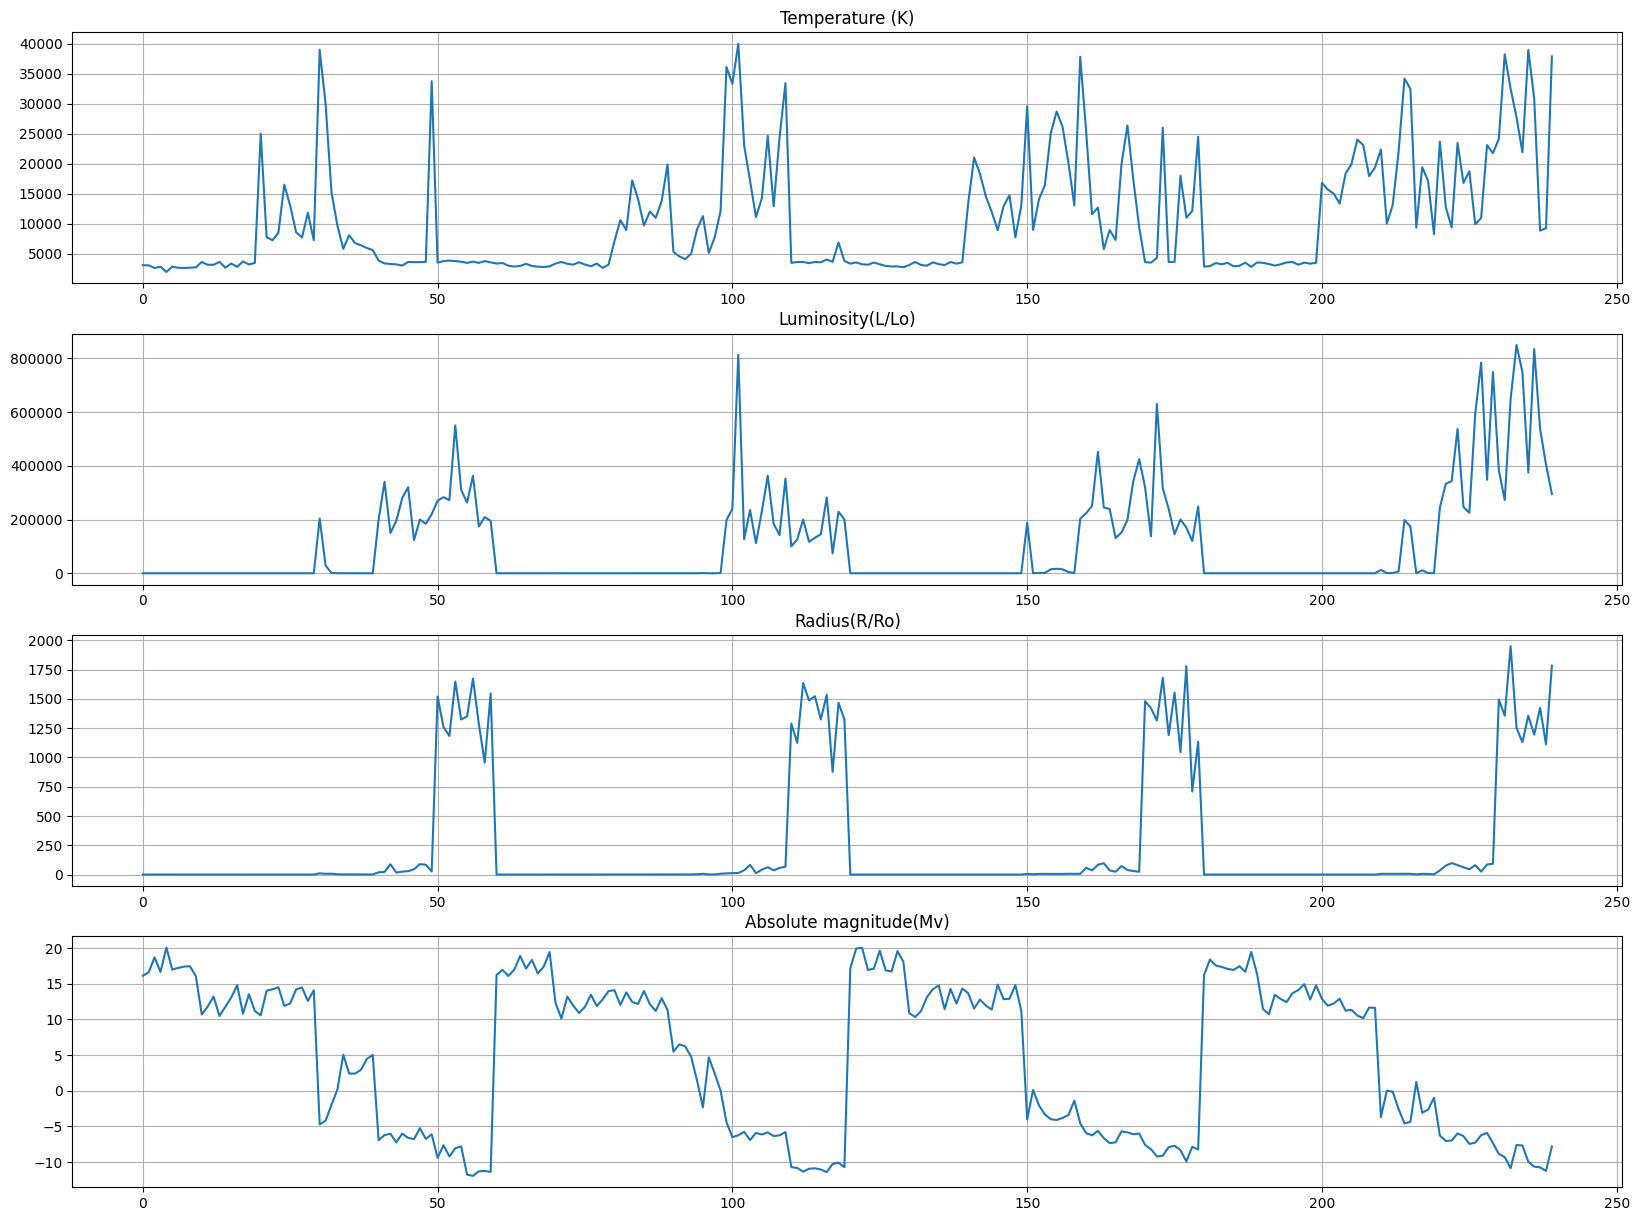

In [15]:
plt.figure(figsize = (20, 15))

for i in range (4):
    plt.subplot(4, 1, i+1)
    df.iloc[:, i].plot()
    plt.title(df.columns[i])
    plt.grid()

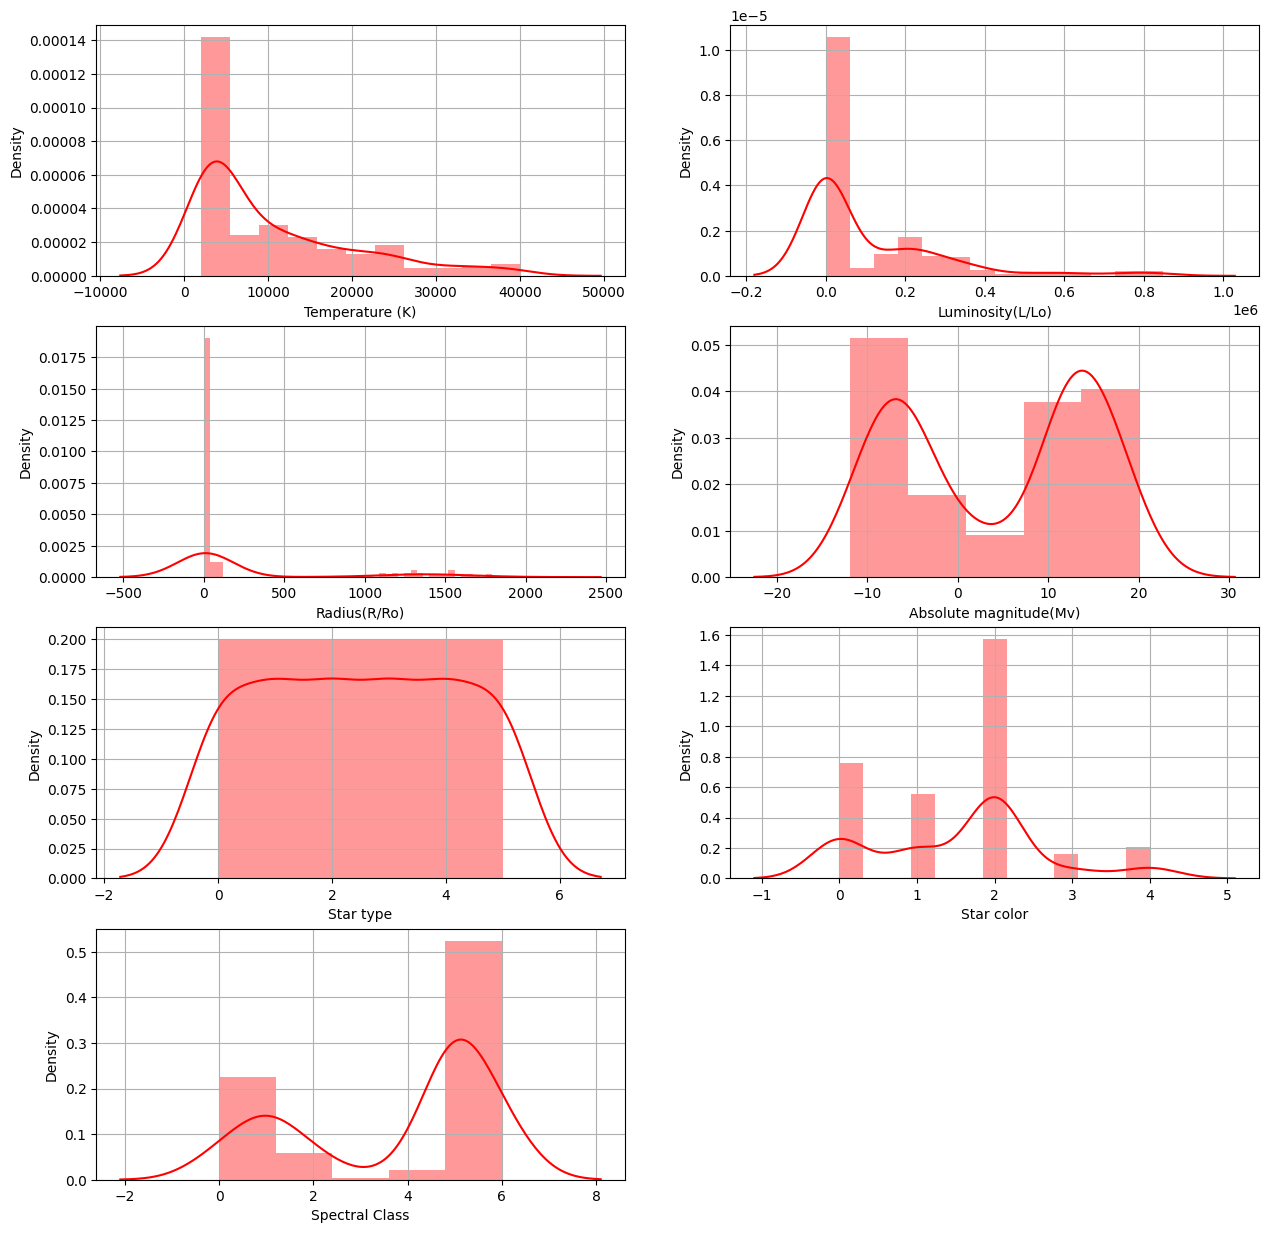

In [16]:
plt.figure(figsize = (15, 15))

for i in range (len(df.columns)):
    plt.subplot(4, 2, i+1)
    sns.distplot(df.iloc[:, i], color = 'red')
    plt.grid()

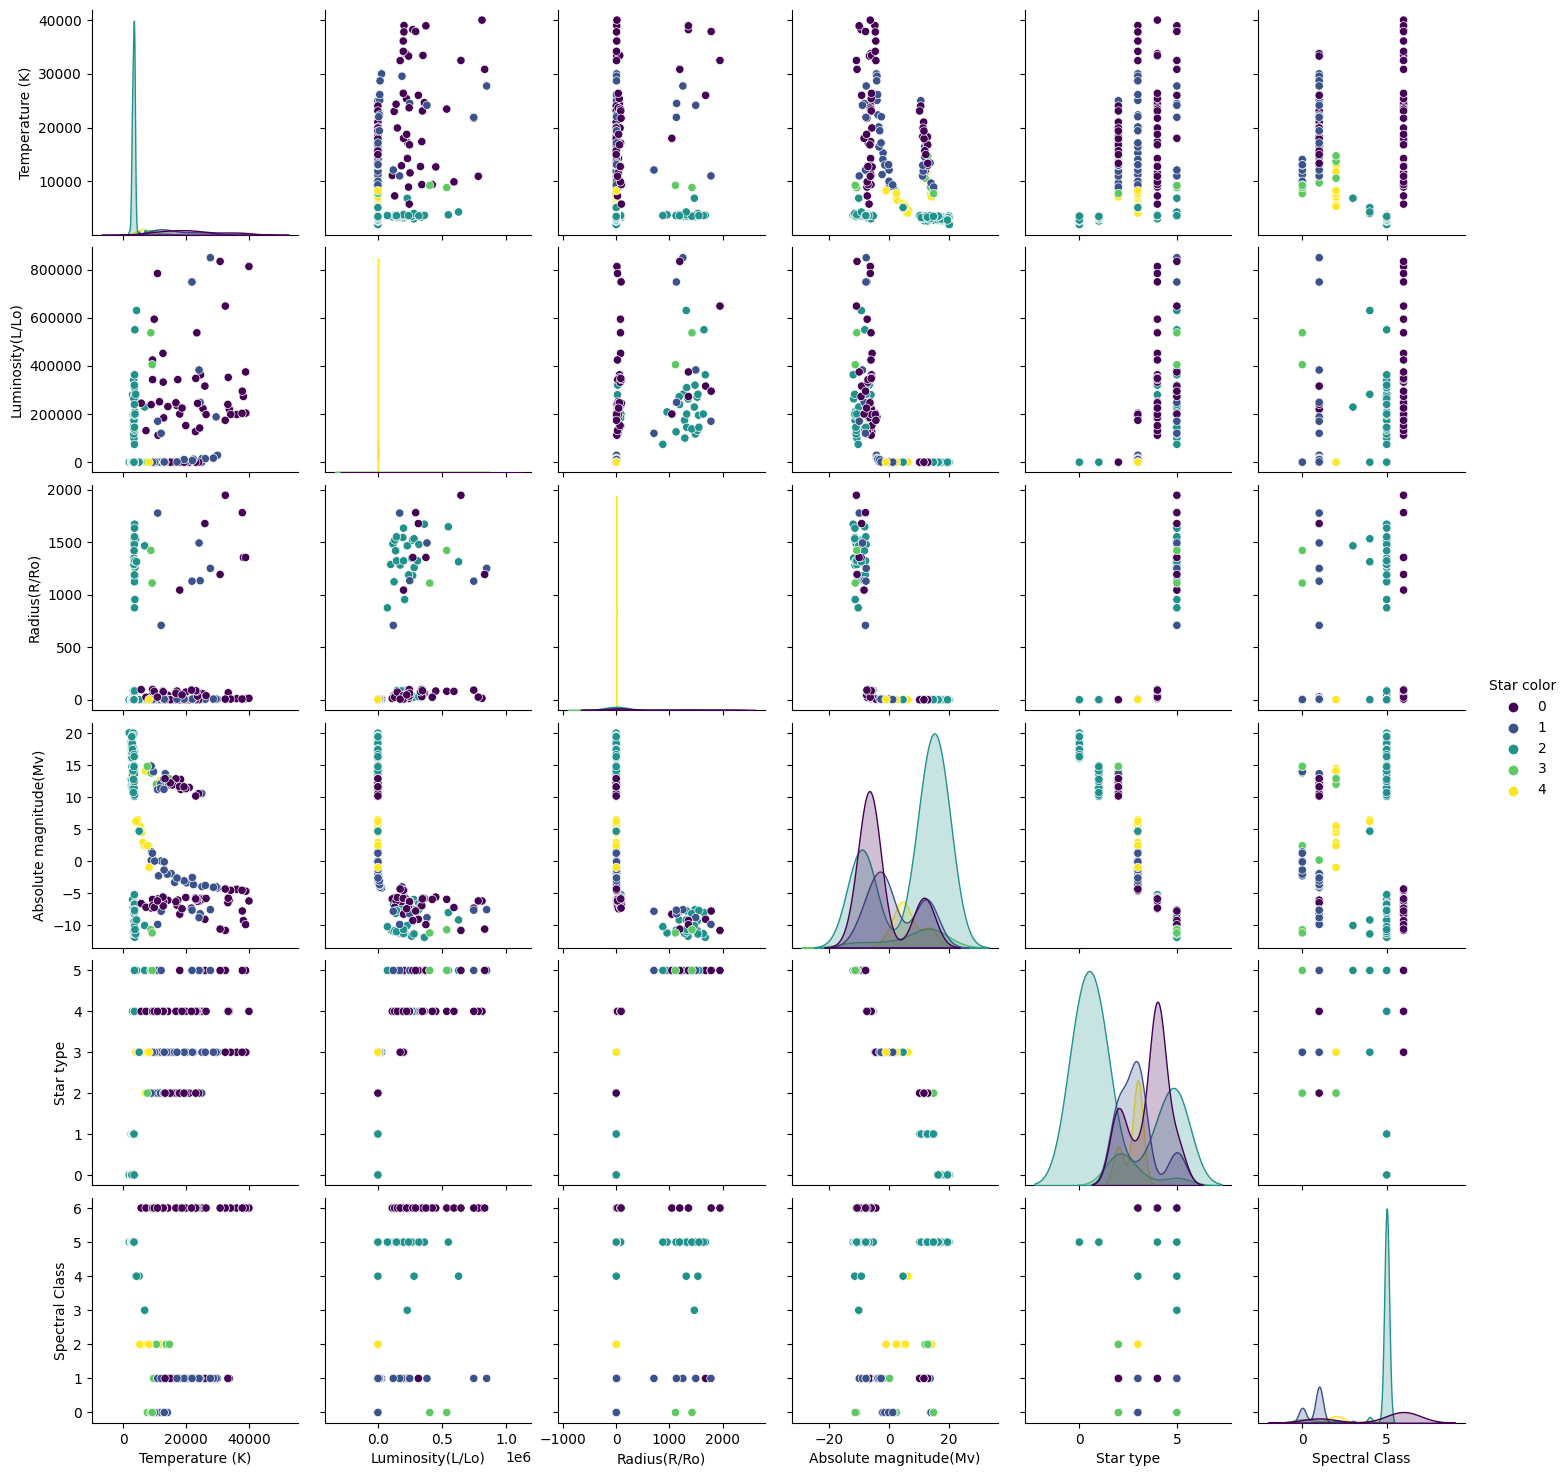

In [17]:
sns.pairplot(df, hue = 'Star color', palette = 'viridis')

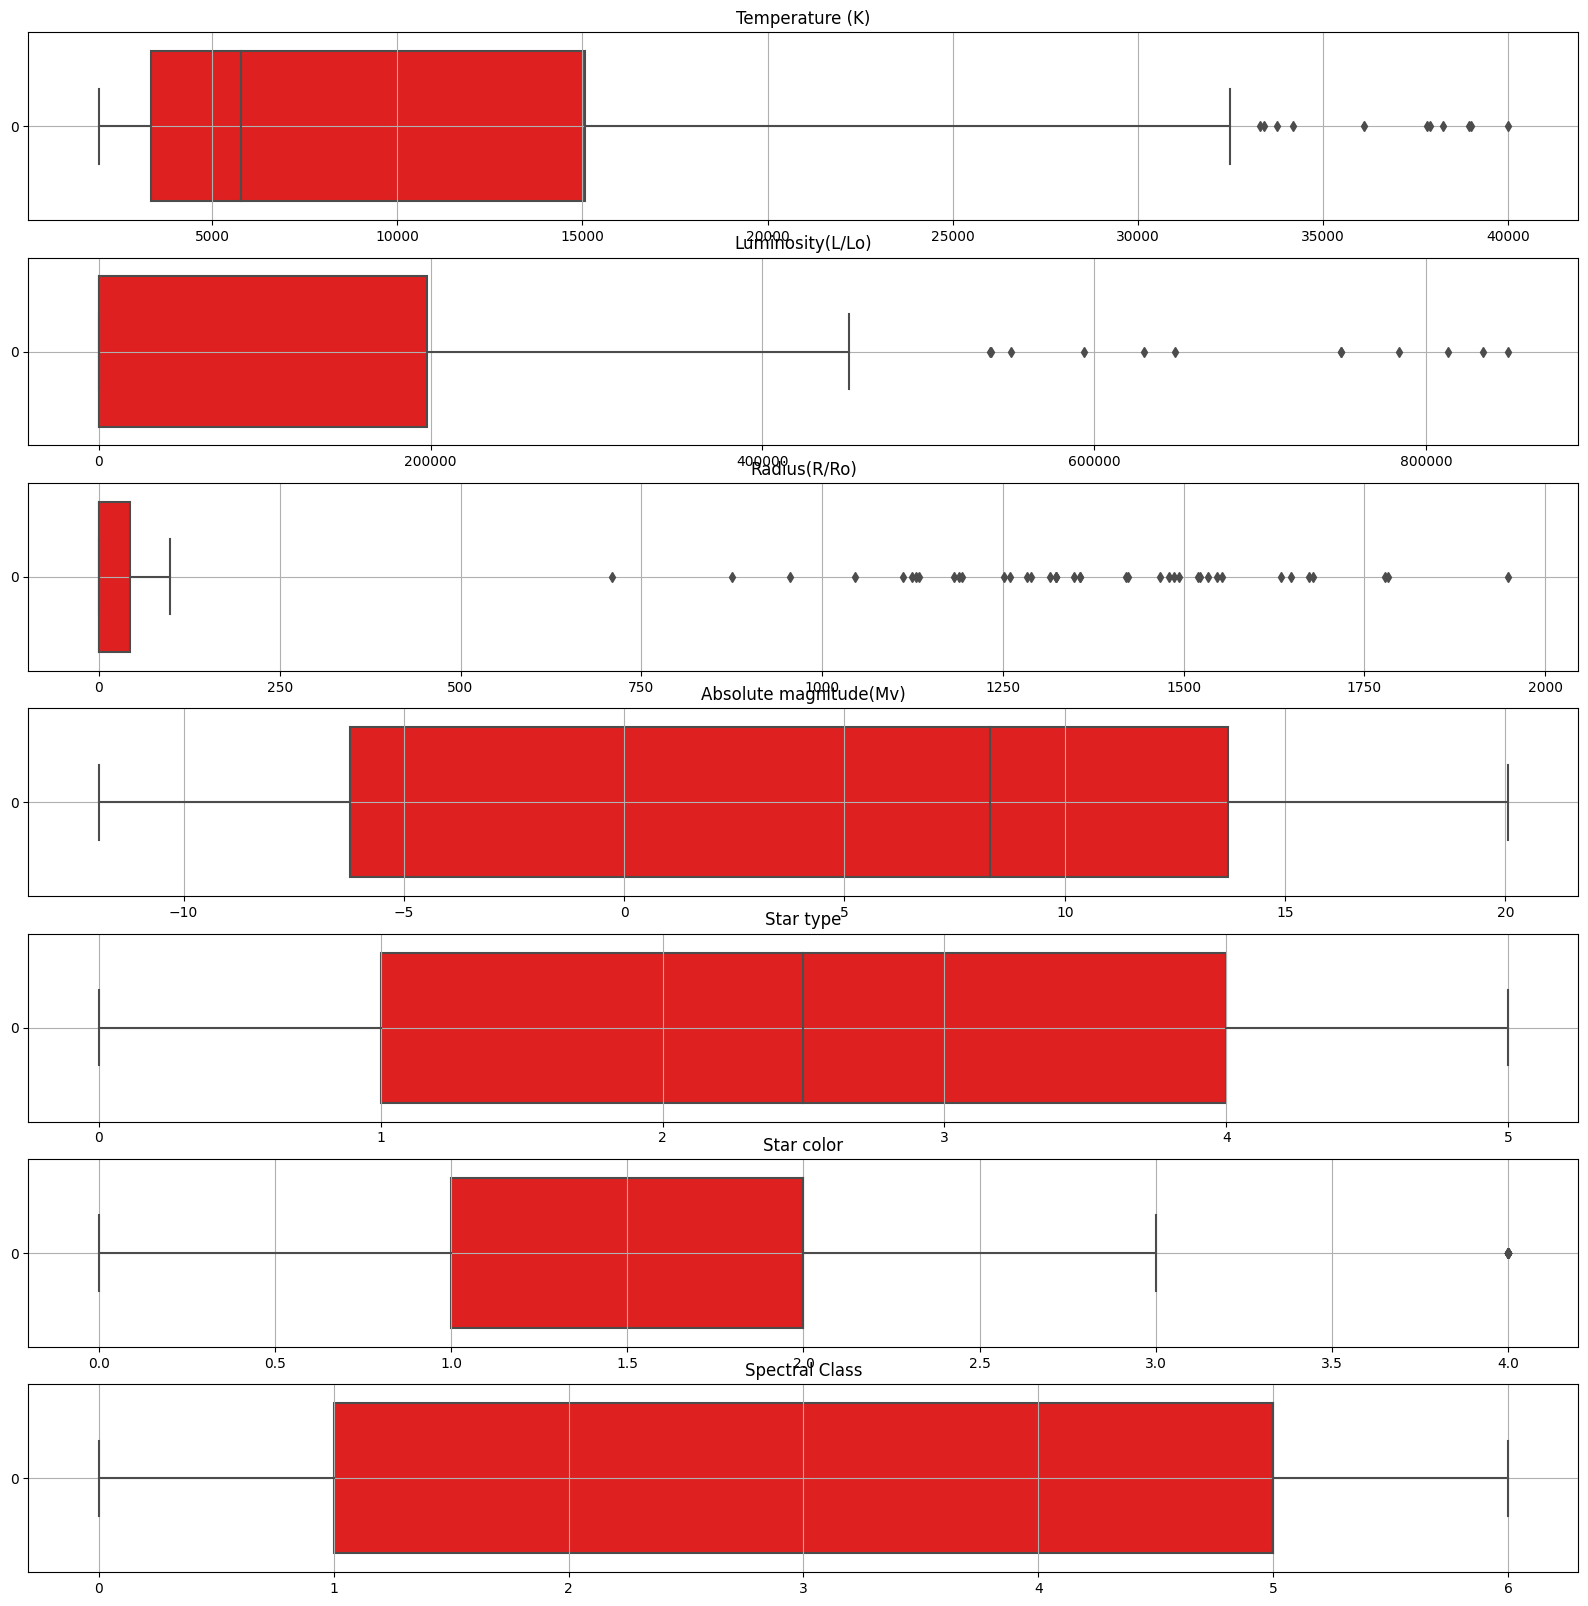

In [18]:
plt.figure(figsize = (20, 20))

for i in range (len(df.columns)):
    plt.subplot(7, 1, i+1)
    sns.boxplot(df.iloc[:, i], color = 'red', orient = 'h')
    plt.title(df.columns[i])
    plt.grid()

In [19]:
z_score = np.abs(zscore(df))

threshold = 3
outlier = df[z_score > threshold]
outlier.notnull().sum()

Temperature (K)           1
Luminosity(L/Lo)          7
Radius(R/Ro)              1
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

In [20]:
df = df[(z_score < threshold).all(axis = 1)]
df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,2,5
1,3042,0.000500,0.1542,16.60,0,2,5
2,2600,0.000300,0.1020,18.70,0,2,5
3,2800,0.000200,0.1600,16.65,0,2,5
4,1939,0.000138,0.1030,20.06,0,2,5
...,...,...,...,...,...,...,...
231,38234,272830.000000,1356.0000,-9.29,5,0,6
235,38940,374830.000000,1356.0000,-9.93,5,0,6
237,8829,537493.000000,1423.0000,-10.73,5,3,0
238,9235,404940.000000,1112.0000,-11.23,5,3,0


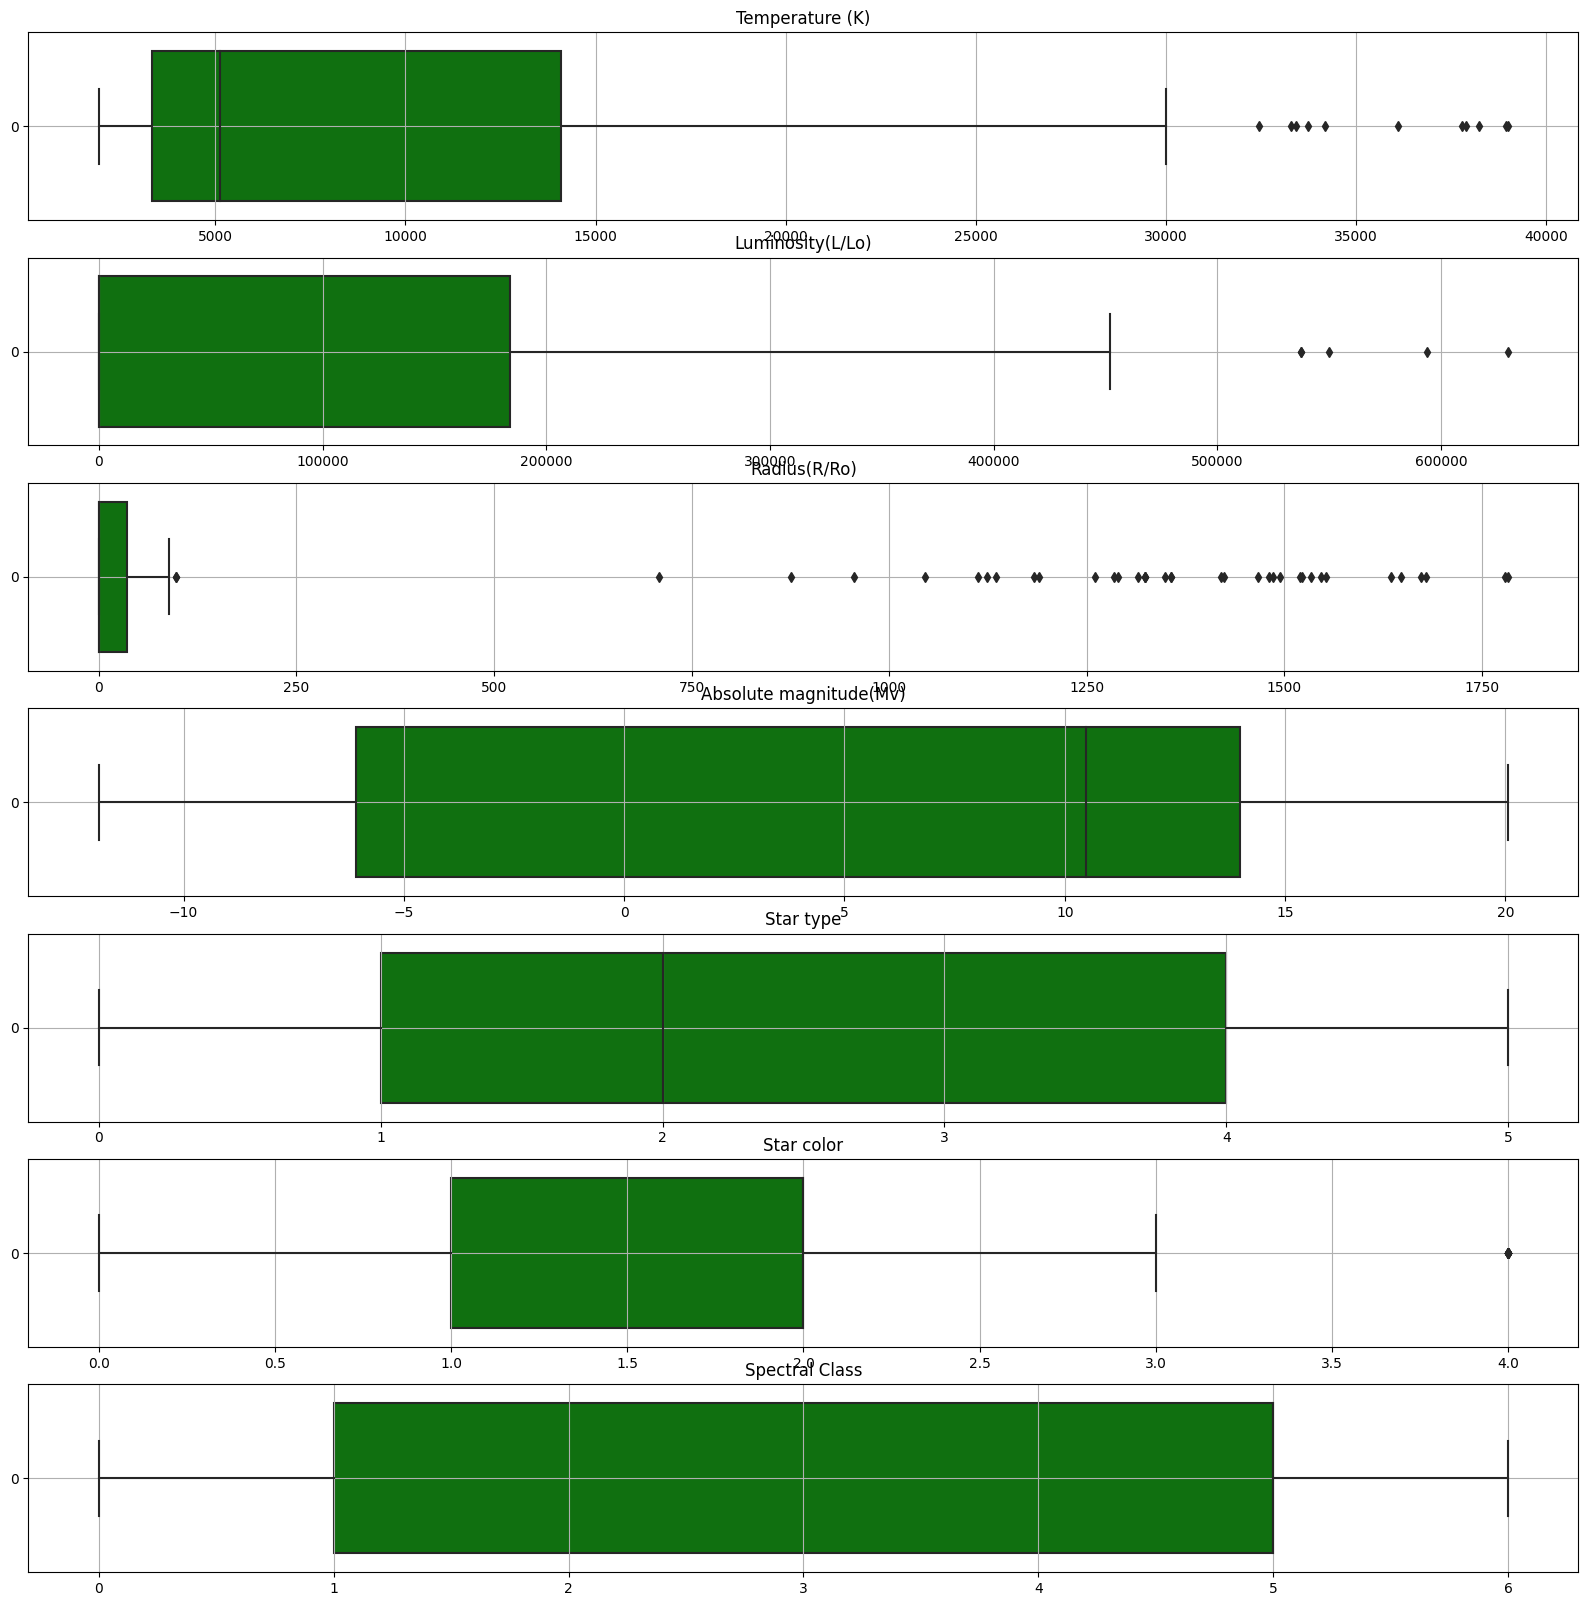

In [21]:
plt.figure(figsize = (20, 20))

for i in range (len(df.columns)):
    plt.subplot(7, 1, i+1)
    sns.boxplot(df.iloc[:, i], color = 'green', orient = 'h')
    plt.title(df.columns[i])
    plt.grid()

<Axes: xlabel='Temperature (K)', ylabel='Luminosity(L/Lo)'>

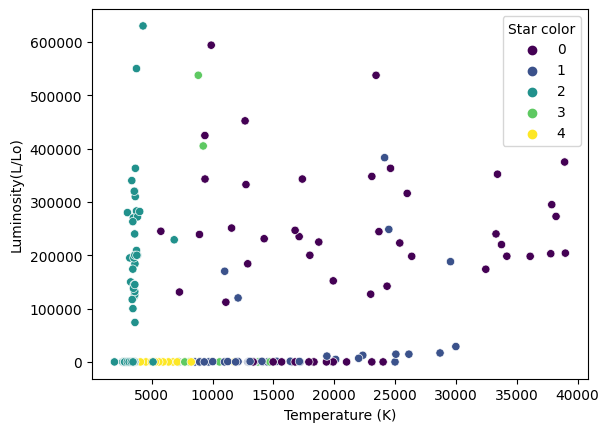

In [22]:
sns.scatterplot(x = df['Temperature (K)'], y = df['Luminosity(L/Lo)'], hue = df['Star color'], palette = 'viridis')

<Axes: xlabel='Temperature (K)', ylabel='Radius(R/Ro)'>

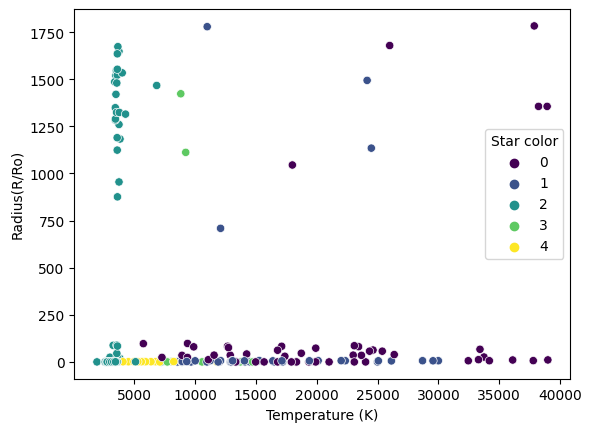

In [23]:
sns.scatterplot(x = df['Temperature (K)'], y = df['Radius(R/Ro)'], hue = df['Star color'], palette = 'viridis')

<Axes: xlabel='Radius(R/Ro)', ylabel='Luminosity(L/Lo)'>

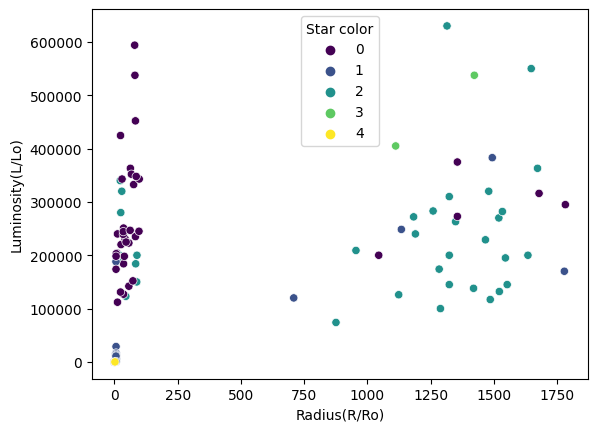

In [24]:
sns.scatterplot(x = df['Radius(R/Ro)'], y = df['Luminosity(L/Lo)'], hue = df['Star color'], palette = 'viridis')

<Axes: xlabel='Absolute magnitude(Mv)', ylabel='Luminosity(L/Lo)'>

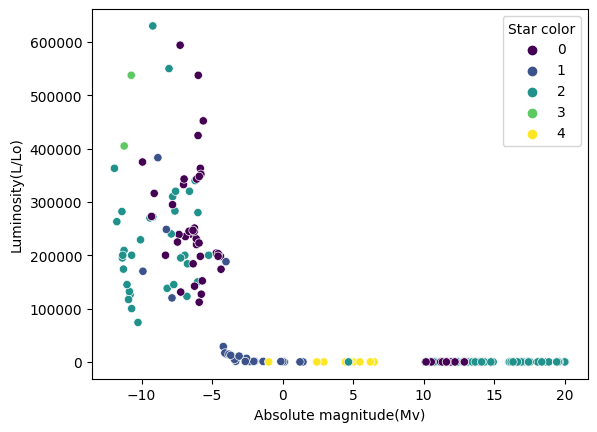

In [25]:
sns.scatterplot(x = df['Absolute magnitude(Mv)'], y = df['Luminosity(L/Lo)'], hue = df['Star color'], palette = 'viridis')

# Train & Test Splitting the Data

In [26]:
x = df.drop('Star type', axis = 1)
x

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,2,5
1,3042,0.000500,0.1542,16.60,2,5
2,2600,0.000300,0.1020,18.70,2,5
3,2800,0.000200,0.1600,16.65,2,5
4,1939,0.000138,0.1030,20.06,2,5
...,...,...,...,...,...,...
231,38234,272830.000000,1356.0000,-9.29,0,6
235,38940,374830.000000,1356.0000,-9.93,0,6
237,8829,537493.000000,1423.0000,-10.73,3,0
238,9235,404940.000000,1112.0000,-11.23,3,0


In [27]:
y = df['Star type'].values
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5])

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2)

# Defining Performance Evaluation Function

In [29]:
def perform(y_pred):
    print(f"Precision = {precision_score(y_test, y_pred, average = 'micro')}")
    print(f"Recall = {recall_score(y_test, y_pred, average = 'micro')}")
    print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
    print(f"F1 Score = {f1_score(y_test, y_pred, average = 'micro')}")
    
    cm = confusion_matrix(y_test, y_pred)
    print(f'\nConfusion Matrix = \n {cm}\n')
    
    print('--'*35)
    print(f'{classification_report(y_test, y_pred, digits = 3)}')
    print('--'*35 + '\n')
    
    cmd = ConfusionMatrixDisplay(confusion_matrix = cm)
    cmd.plot()

# Making Pipeline of XGBoost with MinMaxScaler

In [30]:
pipeline = Pipeline([('MinMaxScaler', MinMaxScaler()), ('XGBoost', XGBClassifier())], verbose = True)
pipeline.fit(x_train, y_train)

[Pipeline] ...... (step 1 of 2) Processing MinMaxScaler, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing XGBoost, total=   0.1s


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))],
         verbose=True)

In [31]:
pipeline.get_params()

{'memory': None,
 'steps': [('MinMaxScaler', MinMaxScaler()),
  ('XGBoost',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=None, n_jobs=None,
                 num_parallel_tree=None, objective='multi:softprob', ...))],
 'verbose': True,
 'MinMaxScaler': MinMaxScaler(),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=Non

In [32]:
y_pred_pl = pipeline.predict(x_test)

Precision = 1.0
Recall = 1.0
Accuracy = 1.0
F1 Score = 1.0

Confusion Matrix = 
 [[ 7  0  0  0  0  0]
 [ 0  7  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 11  0  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  0  0  6]]

----------------------------------------------------------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         7
           1      1.000     1.000     1.000         7
           2      1.000     1.000     1.000        12
           3      1.000     1.000     1.000        11
           4      1.000     1.000     1.000         4
           5      1.000     1.000     1.000         6

    accuracy                          1.000        47
   macro avg      1.000     1.000     1.000        47
weighted avg      1.000     1.000     1.000        47

----------------------------------------------------------------------



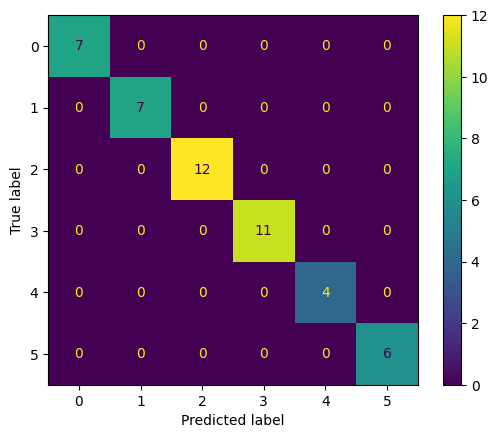

In [33]:
perform(y_pred_pl)

# Making Pipeline of Extra-Tree Classifier with MinMaxScaler

In [34]:
pipeline2 = Pipeline([('MinMaxScaller', MinMaxScaler()), ('ExtraTreeClassifier', ExtraTreesClassifier())], verbose = True)
pipeline2.fit(x_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing MinMaxScaller, total=   0.0s
[Pipeline]  (step 2 of 2) Processing ExtraTreeClassifier, total=   0.2s


Pipeline(steps=[('MinMaxScaller', MinMaxScaler()),
                ('ExtraTreeClassifier', ExtraTreesClassifier())],
         verbose=True)

In [35]:
pipeline2.get_params()

{'memory': None,
 'steps': [('MinMaxScaller', MinMaxScaler()),
  ('ExtraTreeClassifier', ExtraTreesClassifier())],
 'verbose': True,
 'MinMaxScaller': MinMaxScaler(),
 'ExtraTreeClassifier': ExtraTreesClassifier(),
 'MinMaxScaller__clip': False,
 'MinMaxScaller__copy': True,
 'MinMaxScaller__feature_range': (0, 1),
 'ExtraTreeClassifier__bootstrap': False,
 'ExtraTreeClassifier__ccp_alpha': 0.0,
 'ExtraTreeClassifier__class_weight': None,
 'ExtraTreeClassifier__criterion': 'gini',
 'ExtraTreeClassifier__max_depth': None,
 'ExtraTreeClassifier__max_features': 'sqrt',
 'ExtraTreeClassifier__max_leaf_nodes': None,
 'ExtraTreeClassifier__max_samples': None,
 'ExtraTreeClassifier__min_impurity_decrease': 0.0,
 'ExtraTreeClassifier__min_samples_leaf': 1,
 'ExtraTreeClassifier__min_samples_split': 2,
 'ExtraTreeClassifier__min_weight_fraction_leaf': 0.0,
 'ExtraTreeClassifier__n_estimators': 100,
 'ExtraTreeClassifier__n_jobs': None,
 'ExtraTreeClassifier__oob_score': False,
 'ExtraTreeClassi

In [36]:
y_pred_pl2 = pipeline2.predict(x_test)

Precision = 1.0
Recall = 1.0
Accuracy = 1.0
F1 Score = 1.0

Confusion Matrix = 
 [[ 7  0  0  0  0  0]
 [ 0  7  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 11  0  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  0  0  6]]

----------------------------------------------------------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         7
           1      1.000     1.000     1.000         7
           2      1.000     1.000     1.000        12
           3      1.000     1.000     1.000        11
           4      1.000     1.000     1.000         4
           5      1.000     1.000     1.000         6

    accuracy                          1.000        47
   macro avg      1.000     1.000     1.000        47
weighted avg      1.000     1.000     1.000        47

----------------------------------------------------------------------



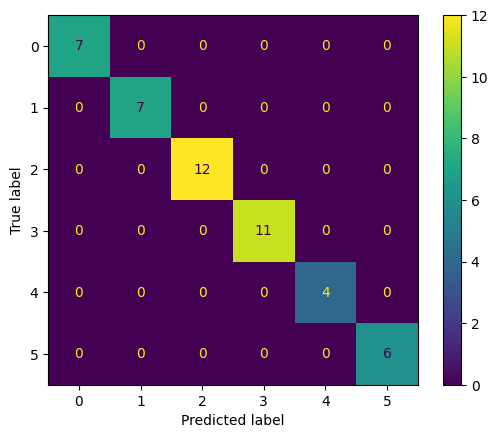

In [37]:
perform(y_pred_pl2)

<br>
<p style="text-align:center; font-weight:800; font-size:18px"><em>Thank you For viewing this Notebook 😃, do upvote 🔼 if you like it and please feel free to provide any feedback.</em>
<p style="text-align:center"><img src="https://download-free-images.com/img/00003/thank-you-771656.gif" width="480" height="200"></p>